Combined dataset saved as 'final_train_test_data.csv'.

Classification Report:

              precision    recall  f1-score   support

       False       0.89      0.58      0.70       811
        True       0.39      0.80      0.53       278

    accuracy                           0.63      1089
   macro avg       0.64      0.69      0.61      1089
weighted avg       0.77      0.63      0.66      1089


AUC-ROC Score: 0.7744


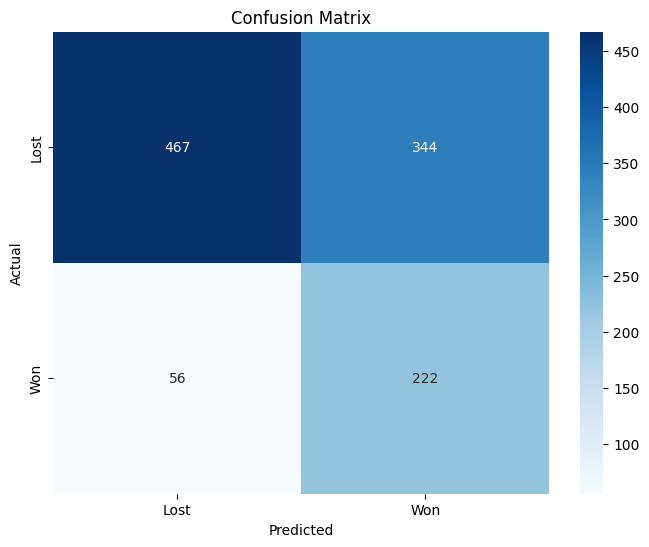

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('updated_Movie_Masterdata.csv')

# Drop rows with missing values and reset index for proper alignment
data = data.dropna().reset_index(drop=True)

# Encode categorical variables
label_encoder = LabelEncoder()
data['Category_Encoded'] = label_encoder.fit_transform(data['Category'])

# Define features (X) and target variable (y)
X = data[['Critic_Score', 'Audience_Score', 'Category_Encoded']]
y = data['Winner']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost model
model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Class balancing
)
model.fit(X_train_scaled, y_train)

# Predict probabilities and adjust decision threshold
threshold = 0.4  # Adjust threshold to favor positive predictions (Oscar win)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

y_train_pred = (y_train_proba >= threshold).astype(int)
y_test_pred = (y_test_proba >= threshold).astype(int)

# Map predictions to True/False
y_train_pred_mapped = pd.Series(y_train_pred, index=X_train.index).map({1: True, 0: False})
y_test_pred_mapped = pd.Series(y_test_pred, index=X_test.index).map({1: True, 0: False})

# Create labeled datasets for training and testing
train_data = data.iloc[X_train.index].copy()
test_data = data.iloc[X_test.index].copy()

# Add predictions and dataset labels
train_data['Predicted_Award_Outcome'] = y_train_pred_mapped
train_data['Prediction_Probability_Win'] = y_train_proba
train_data['Dataset'] = 'Training'

test_data['Predicted_Award_Outcome'] = y_test_pred_mapped
test_data['Prediction_Probability_Win'] = y_test_proba
test_data['Dataset'] = 'Testing'

# Combine training and testing data into a single dataset
final_train_test_data = pd.concat([train_data, test_data], axis=0)

# Save the combined dataset to CSV
final_train_test_data.to_csv("final_train_test_data.csv", index=False)
print("Combined dataset saved as 'final_train_test_data.csv'.")

# ------------------- Optional: Evaluation and Visualization -------------------

# Evaluate the model on the test set
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

# Calculate and print the AUC-ROC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Lost', 'Won'], yticklabels=['Lost', 'Won'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
